In [1]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.7 MB/s eta 0:00:00


In [2]:
import wfdb
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Data labels

In [4]:
labels_set = ('N','S','V','F','Q')
labels_dict = {'N':0,'S':1,'V':2,'F':3,'Q':4}

# Define base folder and test visualization

In [5]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False  # Disable LaTeX rendering
})

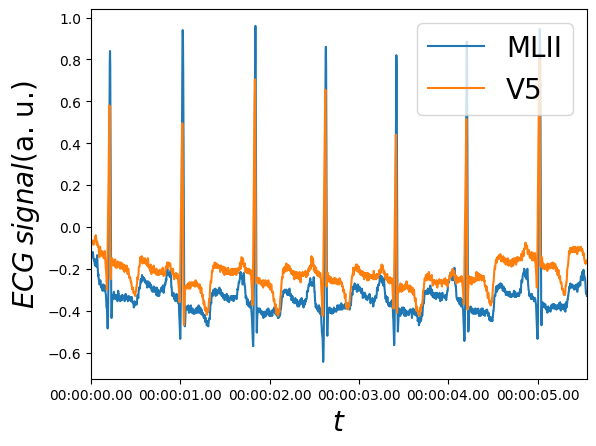

In [7]:
base_fld = './'
data_fld = base_fld + '/mit-bih-arrhythmia-database-1.0.0/'
record = wfdb.rdrecord('/content/drive/MyDrive/CNN_base_case/mit-bih-arrhythmia-database-1.0.0/100', sampto=2000)
df = record.to_dataframe()
df.plot()
plt.xlabel('$t$',fontsize=20)
plt.ylabel('$ECG\:signal$(a. u.)',fontsize=20)
plt.legend(fontsize=20, loc=1)
plt.savefig('data_1.png')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Labeling with labels_set

In [8]:
def get_normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}.
    """
    return np.array(["N", "L", "R", "e", "j"])

def get_abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])

def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

In [9]:
class arrhythmia:
    def __init__(self, data_path):
        self.path = data_path
        self.record = wfdb.rdrecord(data_path)
        self.annotation = wfdb.rdann(data_path, extension='atr')
        self.time = None
        self.time_series = None
        self.R_idx = None

        self.pulse_arr = None
        self.lable_arr = None

    def get_pulse_with_label(self):

        data_path = self.path

        # Extract time series
        record = self.record
        df = record.to_dataframe()
        try:
            time_series = np.array(df['MLII'])
        except:
            time_series = np.array(df['V5'])


        # Extract peak index and labels

        annotation = self.annotation
        idx_arr = annotation.sample                              # idx denotes the peak location known as R based on PQRST convension
        sym_arr = np.array(annotation.symbol)                    # Gives the raw labes
        lab_arr = np.array([get_beat_class(s) for s in sym_arr]) # Labels are assigned from {N,S,V,F,Q}

        # Split
        pulse_arr = []
        pulse_lab = []
        R_idx  = []

        labels_set = ('N','S','V','F','Q')

        for i in range(len(idx_arr)):
            if (lab_arr[i] in labels_set) and ((idx_arr[i]-130)>0) and ((idx_arr[i]+130)<len(time_series)):

                pulse_arr.append(time_series[(idx_arr[i]-130):(idx_arr[i]+130)])
                pulse_lab.append(lab_arr[i])
                R_idx.append(idx_arr[i])

        self.time = np.arange(len(time_series))*record.fs
        self.time_series = time_series
        self.R_idx = np.array(R_idx)

        self.pulse_arr = np.array(pulse_arr)
        self.lable_arr = np.array(pulse_lab)

    def plot_pulse(self, axs, idx):
        axs.plot(self.pulse_arr[idx])
        axs.set_title(self.lable_arr[idx])

    def __repr__(self):
        return "Data from subject '"+self.record.record_name+"'"

In [10]:

def get_all_heart_beats(data_all):
    keys = list(data_all.keys())

    pulse_seg = data_all[keys[0]].pulse_arr
    pulse_lab = data_all[keys[0]].lable_arr

    #print(pulse_seg.shape)

    for key in keys[1::]:
        #print(data_all[key].pulse_arr.shape)
        pulse_seg = np.vstack([pulse_seg, data_all[key].pulse_arr])
        pulse_lab = np.hstack((pulse_lab, data_all[key].lable_arr))
    return pulse_seg, pulse_lab

In [11]:
def get_z_normalized(pulses):
    print(pulses.shape)
    mu = np.mean(pulses, axis=1).reshape(-1,1)
    std = np.std(pulses, axis=1).reshape(-1,1)
    pulses_normed = (pulses-mu)/std

    return pulses_normed

# Data balancing

The number of samples availabel for each class are unequal. The synthetic samples are are generated to balance the disparity between the number of samples.

Let us say the class with maximum samples has $N$ beats and class $C_i$ has $N_i$ beats. Then, $n_i=N-N_i$ synthetic beats are generated for balancing. From $N_i$ beats $n_i$ random beats are selected and $10\%$ noise with normal distribution is added (Here $\sigma$ at each point is different.)

$$
    x_{aug} = x_{sam} + \mathcal{N}(0,\sigma)
$$

Here, $x_{sam}$ is one of the randomly sampled beat from the data and $\mathcal{N}(0,\sigma)$ is the normal distribution with zero mean and standard daviation $\sigma$.

Note: If each beat segment has length $n_w$ then, $x_{sam}$, $\sigma$, $x_{aug}$ are also of length $n_w$.

In [12]:
def get_balanced_data(pulses, labels):
    #labels_set = list(set(labels))

    seg_len = pulses.shape[1]
    #print(seg_len)
    number_of_beats = []

    for l in labels_set:
        number_of_beats.append(sum(labels==l))

    number_of_beats = np.array(number_of_beats)

    max_num_of_beats = max(number_of_beats)

    required_num_of_beats = max_num_of_beats - number_of_beats

    pulses_aug = pulses.copy()
    labels_aug = labels.copy()

    for i in range(len(labels_set)):
        print("Balancing for ", labels_set[i])

        n      = required_num_of_beats[i]

        pulses_sel = pulses[labels==labels_set[i]]
        pulse_mean = np.mean(pulses_sel, axis=0)
        pulse_std  = np.std(pulses_sel, axis=0)


        id_sel     = np.random.randint(number_of_beats[i], size=n)
        pulses_sel = pulses_sel[id_sel,:]

        noise_level = pulse_std*0.1
        noise       = np.random.normal(0,1,(n,seg_len))* noise_level

        pulse_temp = pulses_sel + noise
        pulses_aug = np.vstack([pulses_aug, pulse_temp])

        labels_temp= np.array([labels_set[i]]*n)
        labels_aug = np.hstack([labels_aug, labels_temp])

        ##
        fig = plt.figure()
        axs = fig.add_subplot(1,1,1)
        axs.plot(pulse_mean,           label='Mean pulse($\mu$)')
        axs.plot(pulse_mean+pulse_std, label='$\mu+\sigma$'     )
        axs.plot(pulse_mean-pulse_std, label='$\mu-\sigma$'     )
        if n>0:
            axs.plot(pulses_sel[ 0,:],     label='Sample real'      )
        axs.plot(pulses_aug[-1,:],     label='Sample augmented' )

        axs.set_xlim([0,len(pulse_mean)])

        axs.set_title(labels_set[i], fontsize=20)
        plt.xlabel('$t$',fontsize=20)
        plt.ylabel('$ECG\:signal$(a. u.)',fontsize=20)
        plt.legend(fontsize=10, loc=1)

        plt.savefig("aug_"+str(i)+".png")
    return pulses_aug, labels_aug

# Get names of all the files

In [13]:
file_names = np.loadtxt('/content/drive/MyDrive/CNN_base_case/mit-bih-arrhythmia-database-1.0.0/RECORDS',dtype=str)
file_names

array(['100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '121', '122', '123', '124', '200', '201', '202', '203',
       '205', '207', '208', '209', '210', '212', '213', '214', '215',
       '217', '219', '220', '221', '222', '223', '228', '230', '231',
       '232', '233', '234'], dtype='<U3')

# Read data from all the files

In [14]:
data_all = {}
for file in file_names:
    data_obj = arrhythmia('/content/drive/MyDrive/CNN_base_case/mit-bih-arrhythmia-database-1.0.0'+'/'+file)
    data_obj.get_pulse_with_label()
    data_all[str(file)] = data_obj

#data_all

# Get pulses and corresponding labels

In [16]:
pulse_all, labels_all = get_all_heart_beats(data_all)

# Check number of beats in each catagory

In [17]:
for l in labels_set:
    print("Number of beats in class ",l,':',sum(labels_all==l))

Number of beats in class  N : 90593
Number of beats in class  S : 2781
Number of beats in class  V : 7235
Number of beats in class  F : 802
Number of beats in class  Q : 33


# Normalize the beats

In [18]:
pulses_normed = get_z_normalized(pulse_all)

(101444, 260)


# Balancing of the data

In [ ]:
pulses_bal, labels_bal = get_balanced_data(pulse_all, labels_all)

# Check number of beats in each catagory for balanced data

In [20]:
for l in labels_set:
    print("Number of beats in class ",l,':',sum(labels_bal==l))

Number of beats in class  N : 90593
Number of beats in class  S : 90593
Number of beats in class  V : 90593
Number of beats in class  F : 90593
Number of beats in class  Q : 90593


# Convert labels to numbers

In [22]:
labels_int = np.zeros(len(labels_bal))
for l in labels_set:
    labels_int[labels_bal==l] = labels_dict[l]

# Visualize class distribution

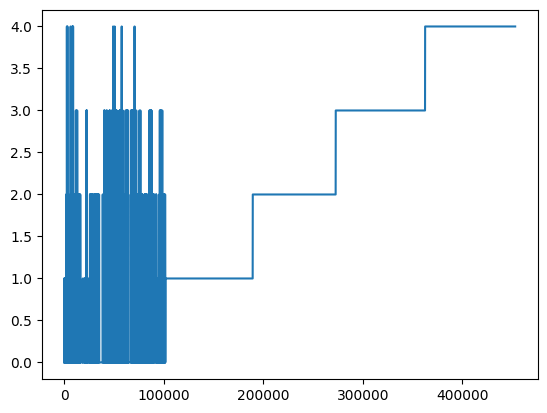

In [23]:
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs.plot(labels_int)

# Classification using CNN

# Convert data to tensor

In [24]:
m, n = pulses_bal.shape

data_in, labels_in = torch.tensor(pulses_bal.reshape(m,1,n)), torch.tensor(labels_int)
data_in, labels_in = data_in.float(), labels_in.long()

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1,5,3)
        self.conv2 = nn.Conv1d(5,10,4)
        self.conv3 = nn.Conv1d(10,20,4)

        self.pool  = nn.MaxPool1d(2, stride=2)
        self.fc1   = nn.Linear(20*30, 30)
        self.fc2   = nn.Linear(30,20)
        self.fc3   = nn.Linear(20,5)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.pool(F.relu(x))
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.pool(F.relu(x))
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.pool(F.relu(x))
        #print(x.shape)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.softmax(self.fc3(x), dim=1)
        #print(x.shape)
        return x

net = Net()

In [26]:
test_out = net(data_in[0:10])

# Define loss function and optimizer

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

# Train the network

In [30]:
'''for epoch in range(2):

    running_loss = 0.0
    N = len(data_in)
    n = 1000
    for i in tqdm(range(1000)):

        idx_rnd = torch.randint(0,N, size=(n,))

        # get the inputs the data is the list of [inputs, labels]
        inputs, labels = data_in[idx_rnd,:,:], labels_in[idx_rnd]
        #print(inputs.shape)

        # zero the parameter gradient
        optimizer.zero_grad()

        # forward -> backward -> optimize
        outputs = net(inputs)
        loss    = criterion(outputs,labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i%2000 ==1999:
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0

    print("Finish training.")'''

from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# Apply data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Assuming data_in and labels_in are numpy arrays
# dataset = TensorDataset(torch.from_numpy(data_in).float(), torch.from_numpy(labels_in))
dataset = TensorDataset(data_in.float(), labels_in)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(2):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        # forward -> backward -> optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}] loss: {running_loss/len(train_loader):.3f}')


# GOT 95% ACCURACY FOR 2 EPOCHS

100%|██████████| 14156/14156 [01:52<00:00, 125.53it/s]


Epoch [1] loss: 1.065


100%|██████████| 14156/14156 [01:43<00:00, 137.09it/s]

Epoch [2] loss: 0.972


In [32]:
# Apply data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Assuming data_in and labels_in are numpy arrays
# dataset = TensorDataset(torch.from_numpy(data_in).float(), torch.from_numpy(labels_in))
dataset = TensorDataset(data_in.float(), labels_in)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(5):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        # forward -> backward -> optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}] loss: {running_loss/len(train_loader):.3f}')

100%|██████████| 14156/14156 [01:46<00:00, 133.28it/s]


Epoch [1] loss: 0.923


100%|██████████| 14156/14156 [02:01<00:00, 116.04it/s]


Epoch [2] loss: 0.917


100%|██████████| 14156/14156 [02:04<00:00, 113.57it/s]


Epoch [3] loss: 0.915


100%|██████████| 14156/14156 [02:02<00:00, 115.70it/s]


Epoch [4] loss: 0.915


100%|██████████| 14156/14156 [02:08<00:00, 109.93it/s]

Epoch [5] loss: 0.914


# Test the network on the test data

In [33]:
correct = 0
total = 0

with torch.no_grad():
    N = len(data_in)
    n = 20
    for i in tqdm(range(1000)):

        idx_rnd = torch.randint(0,N, size=(n,))
        images, labels = data_in[idx_rnd,:,:], labels_in[idx_rnd]

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted==labels).sum().item()

print(f'Accuracy of the network on the 10000 samples: {100*correct//total} %')

100%|██████████| 1000/1000 [00:01<00:00, 822.71it/s]


Accuracy of the network on the 10000 samples: 99 %


In [ ]:
torch.save(net.state_dict(), './CNN_state_dict.sd')